### This project aims to predict Cavity Growth Rate (CGR) in Underground Coal Gasification (UCG) processes using supervised machine learning models and Cluster Analysis and Anomaly detection using unsupervised learning techniques.

Step 1: Data Preprocessing

Missing values:
 Fixed carbon          0
Volatile matter       0
Ash                   0
Moisture              0
Seam thickness        0
Seam depth            0
Operating pressure    0
Permeability          0
Calorific value       0
CGR                   0
dtype: int64

Data types:
 Fixed carbon          float64
Volatile matter       float64
Ash                   float64
Moisture              float64
Seam thickness          int64
Seam depth            float64
Operating pressure    float64
Permeability          float64
Calorific value       float64
CGR                   float64
dtype: object


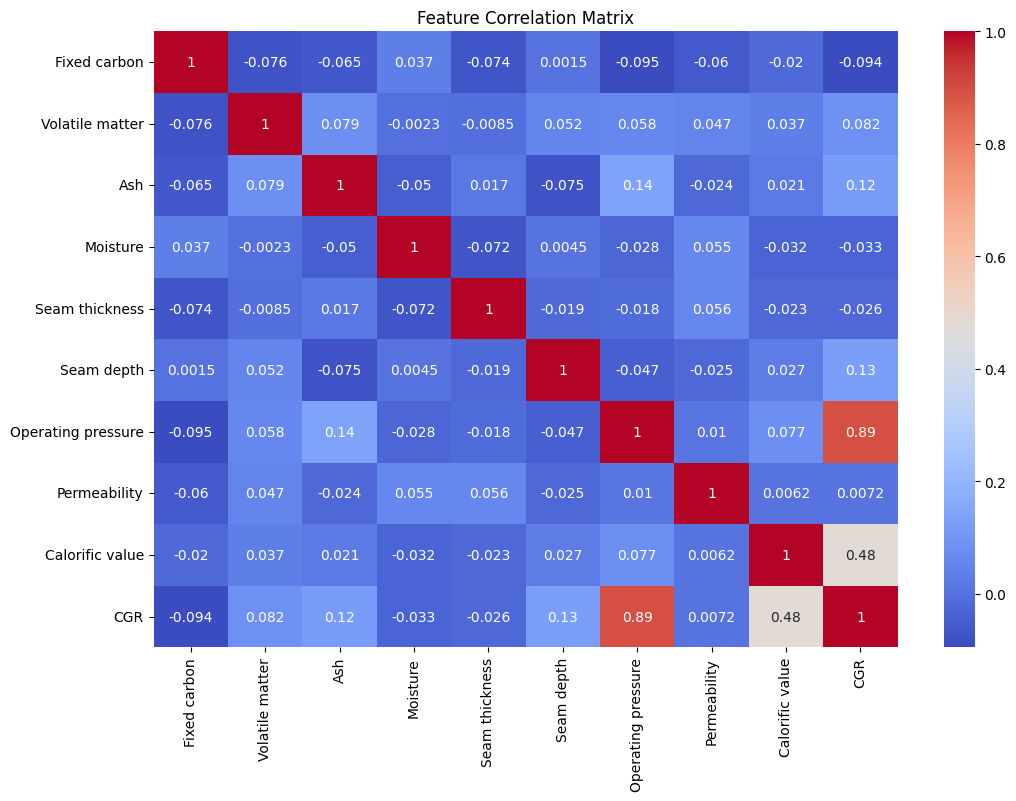

Selected features based on correlation: ['Ash', 'Seam depth', 'Operating pressure', 'Calorific value']


['ucg_scaler.pkl']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_excel('UCG Data.xlsx')

# Check for missing values
print("Missing values:\n", data.isnull().sum())

# Check data types
print("\nData types:\n", data.dtypes)

# Separate features and target for supervised learning
X = data.drop('CGR', axis=1)
y = data['CGR']

# Feature selection - Select top features based on correlation with CGR
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# Select features with correlation > 0.1 with CGR (absolute value)
selected_features = correlation_matrix['CGR'][abs(correlation_matrix['CGR']) > 0.1].index.tolist()
selected_features.remove('CGR')  # Remove target variable

print("Selected features based on correlation:", selected_features)

# Update X with selected features
X = X[selected_features]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for later use in deployment
import joblib
joblib.dump(scaler, 'ucg_scaler.pkl')

Step 2: Supervised Learning Models for CGR Prediction

2.1 Artificial Neural Network (ANN)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


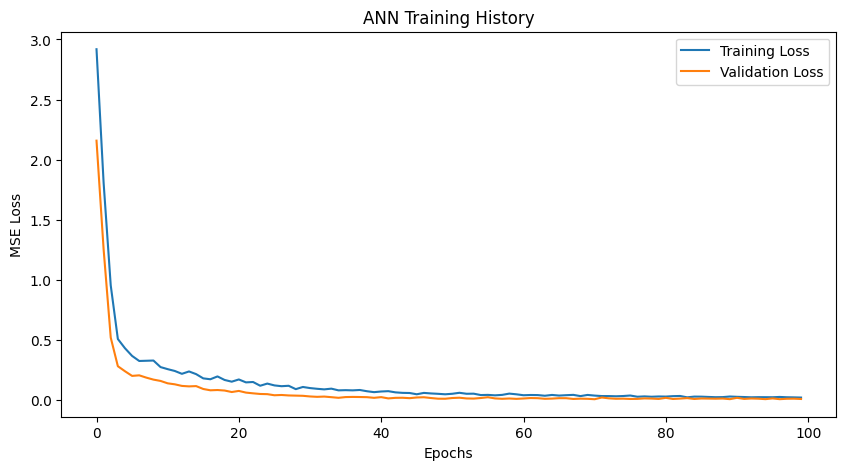

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


ANN R2 Score: 0.9615
ANN MSE: 0.0078


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_squared_error

# Build ANN model
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile the model
ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = ann_model.fit(X_train_scaled, y_train,
                        validation_split=0.2,
                        epochs=100,
                        batch_size=32,
                        verbose=0)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ANN Training History')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Evaluate on test set
y_pred_ann = ann_model.predict(X_test_scaled)
r2_ann = r2_score(y_test, y_pred_ann)
mse_ann = mean_squared_error(y_test, y_pred_ann)

print(f"ANN R2 Score: {r2_ann:.4f}")
print(f"ANN MSE: {mse_ann:.4f}")

# Save ANN model
ann_model.save('ucg_ann_model.h5')

2.2 Support Vector Regression (SVR)

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Parameter grid for SVR
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['rbf', 'linear']
}

# Grid search with cross-validation
svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
best_svr = grid_search.best_estimator_
print("Best SVR parameters:", grid_search.best_params_)

# Evaluate on test set
y_pred_svr = best_svr.predict(X_test_scaled)
r2_svr = r2_score(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)

print(f"SVR R2 Score: {r2_svr:.4f}")
print(f"SVR MSE: {mse_svr:.4f}")

# Save SVR model
joblib.dump(best_svr, 'ucg_svr_model.pkl')

Best SVR parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
SVR R2 Score: 0.9881
SVR MSE: 0.0024


['ucg_svr_model.pkl']

2.3 Random Forest Regression

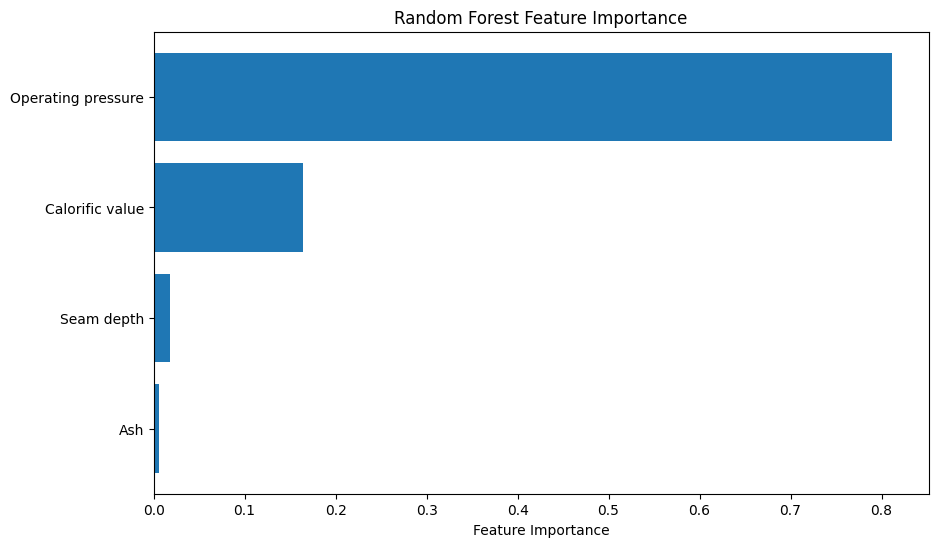

Random Forest R2 Score: 0.9659
Random Forest MSE: 0.0069


['ucg_rf_model.pkl']

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# Initialize and train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)  # No scaling needed for Random Forest

# Feature importance
feature_importance = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(selected_features)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# Evaluate on test set
y_pred_rf = rf_model.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print(f"Random Forest R2 Score: {r2_rf:.4f}")
print(f"Random Forest MSE: {mse_rf:.4f}")

# Save Random Forest model
joblib.dump(rf_model, 'ucg_rf_model.pkl')

2.4 Gradient Boosting Regression

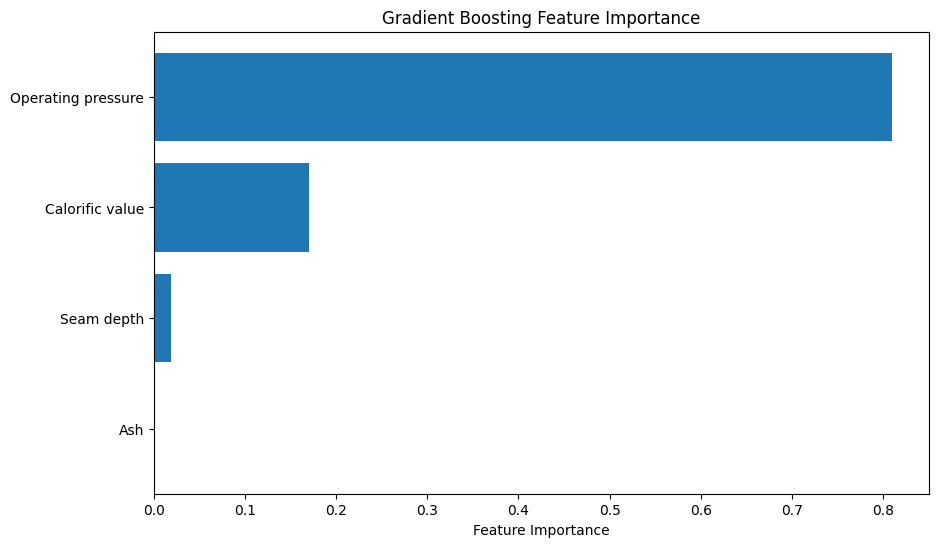

Gradient Boosting R2 Score: 0.9740
Gradient Boosting MSE: 0.0053


['ucg_gb_model.pkl']

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize and train Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Feature importance
gb_feature_importance = gb_model.feature_importances_
gb_sorted_idx = np.argsort(gb_feature_importance)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(len(gb_sorted_idx)), gb_feature_importance[gb_sorted_idx], align='center')
plt.yticks(range(len(gb_sorted_idx)), np.array(selected_features)[gb_sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Gradient Boosting Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# Evaluate on test set
y_pred_gb = gb_model.predict(X_test)
r2_gb = r2_score(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)

print(f"Gradient Boosting R2 Score: {r2_gb:.4f}")
print(f"Gradient Boosting MSE: {mse_gb:.4f}")

# Save Gradient Boosting model
joblib.dump(gb_model, 'ucg_gb_model.pkl')

2.5 Supervised Models Comparison


Model Comparison:
                       Model  R2 Score       MSE
1  Support Vector Regression  0.988137  0.002405
3          Gradient Boosting  0.974041  0.005264
2              Random Forest  0.965946  0.006905
0  Artificial Neural Network  0.961518  0.007803


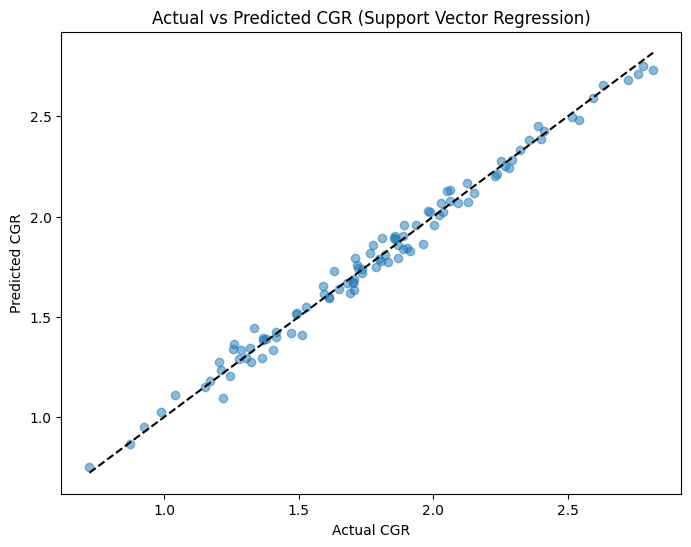

In [ ]:
# Compare all supervised models
results = pd.DataFrame({
    'Model': ['Artificial Neural Network', 'Support Vector Regression', 'Random Forest', 'Gradient Boosting'],
    'R2 Score': [r2_ann, r2_svr, r2_rf, r2_gb],
    'MSE': [mse_ann, mse_svr, mse_rf, mse_gb]
})

print("\nModel Comparison:")
print(results.sort_values(by='R2 Score', ascending=False))

# Plot actual vs predicted for the best model
best_model_name = results.loc[results['R2 Score'].idxmax(), 'Model']
if best_model_name == 'Artificial Neural Network':
    y_pred_best = y_pred_ann
elif best_model_name == 'Support Vector Regression':
    y_pred_best = y_pred_svr
elif best_model_name == 'Random Forest':
    y_pred_best = y_pred_rf
else:
    y_pred_best = y_pred_gb

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual CGR')
plt.ylabel('Predicted CGR')
plt.title(f'Actual vs Predicted CGR ({best_model_name})')
plt.show()

# Save final results
data.to_csv('ucg_data_with_clusters_and_anomalies.csv', index=False)

Step 3: Unsupervised Learning Models for Clustering Analysis / Anomaly Detection

3.1 K-Means Clustering for clustering analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Fixed carbon        500 non-null    float64
 1   Volatile matter     500 non-null    float64
 2   Ash                 500 non-null    float64
 3   Moisture            500 non-null    float64
 4   Seam thickness      500 non-null    int64  
 5   Seam depth          500 non-null    float64
 6   Operating pressure  500 non-null    float64
 7   Permeability        500 non-null    float64
 8   Calorific value     500 non-null    float64
 9   CGR                 500 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 39.2 KB
None
       Fixed carbon  Volatile matter         Ash    Moisture  Seam thickness  \
count    500.000000       500.000000  500.000000  500.000000      500.000000   
mean       0.347738         0.304937    0.247569    2.138935        6.448000   
std        

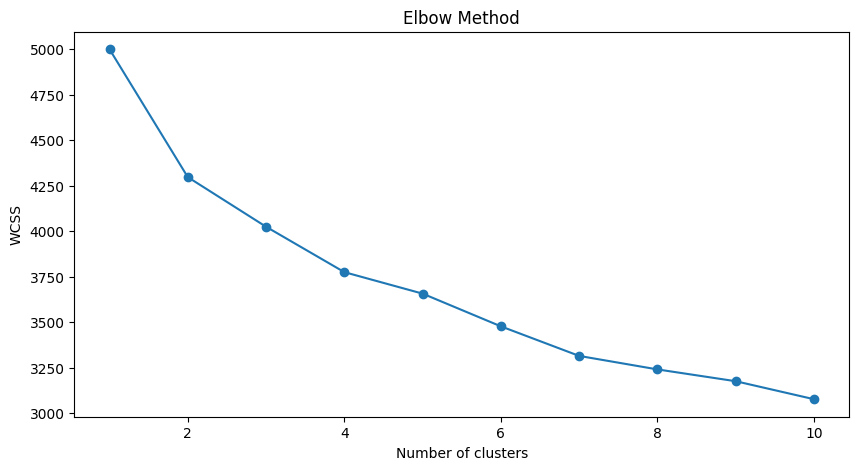

For n_clusters=2, the silhouette score is 0.139
For n_clusters=3, the silhouette score is 0.101
For n_clusters=4, the silhouette score is 0.098
For n_clusters=5, the silhouette score is 0.091
For n_clusters=6, the silhouette score is 0.093
For n_clusters=7, the silhouette score is 0.097
For n_clusters=8, the silhouette score is 0.088
For n_clusters=9, the silhouette score is 0.083
For n_clusters=10, the silhouette score is 0.085


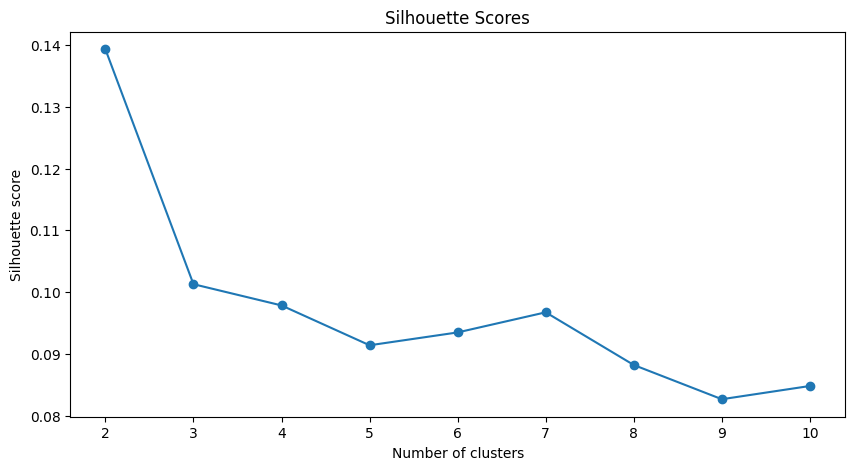

         Fixed carbon  Volatile matter       Ash  Moisture  Seam thickness  \
Cluster                                                                      
0            0.341085         0.291789  0.222061  1.362477        7.500000   
1            0.362268         0.292987  0.248345  4.419076        6.336364   
2            0.327610         0.307317  0.266147  1.742974        6.241379   
3            0.360477         0.326948  0.258037  1.422063        5.590909   

         Seam depth  Operating pressure  Permeability  Calorific value  \
Cluster                                                                  
0        181.968092         1014.726703      0.113399      4322.397134   
1        222.889508         1570.422971      0.101589      4817.023517   
2        235.499454         3819.328708      0.103088      5237.170008   
3        334.437167         1417.771802      0.057984      4968.030637   

              CGR  
Cluster            
0        1.311565  
1        1.609563  
2     

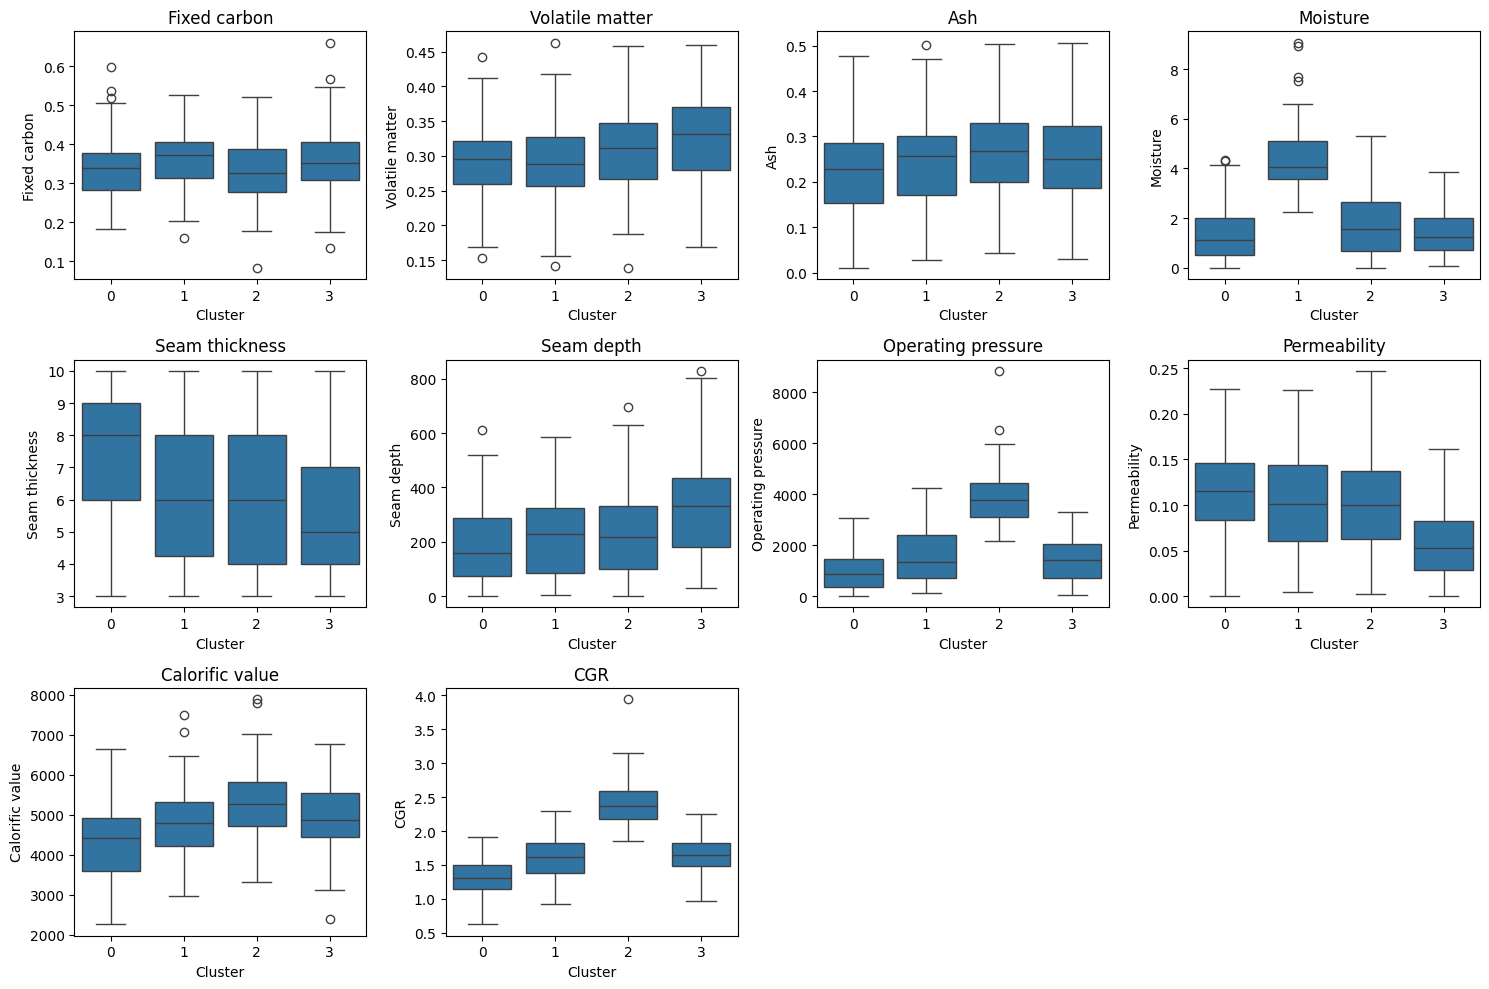

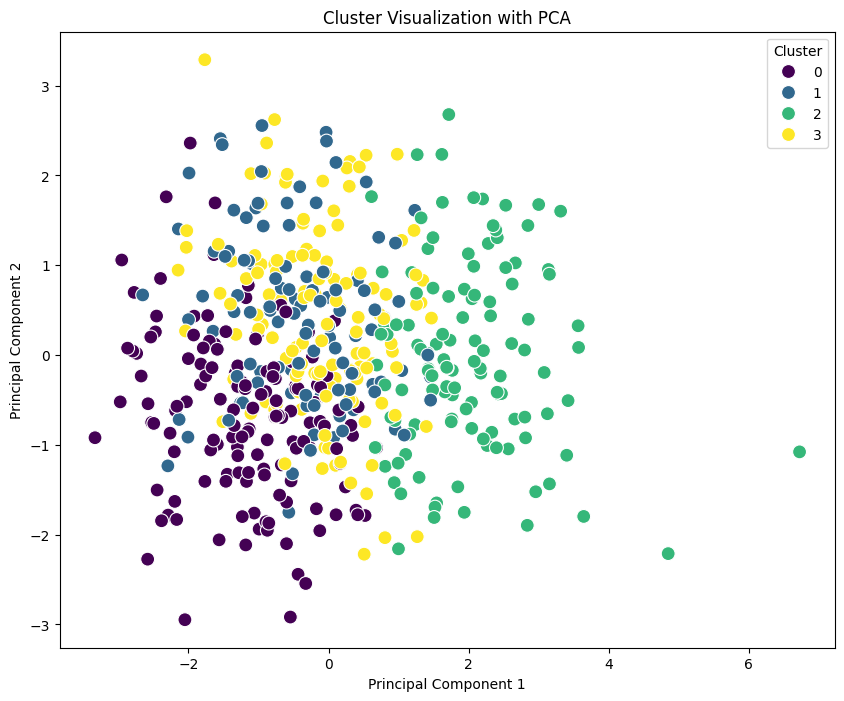

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Load the data
data = pd.read_excel('UCG Data.xlsx')

# Display basic info
print(data.info())
print(data.describe())

features = ['Fixed carbon', 'Volatile matter', 'Ash', 'Moisture',
            'Seam thickness', 'Seam depth', 'Operating pressure',
            'Permeability', 'Calorific value', 'CGR']

X = data[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Silhouette score
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters={i}, the silhouette score is {silhouette_avg:.3f}")

plt.figure(figsize=(10,5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

# Apply K-means with 4 clusters
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to original data
data['Cluster'] = clusters

# Cluster statistics
cluster_stats = data.groupby('Cluster')[features].mean()
print(cluster_stats)

# Visualize cluster characteristics
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 4, i+1)
    sns.boxplot(x='Cluster', y=feature, data=data)
    plt.title(feature)
plt.tight_layout()
plt.show()

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,8))
sns.scatterplot(x=principal_components[:,0], y=principal_components[:,1],
                hue=data['Cluster'], palette='viridis', s=100)
plt.title('Cluster Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Interpretation of Clusters

Based on the cluster statistics, we can characterize each cluster:

Cluster 0: High fixed carbon, moderate volatile matter, low ash, moderate moisture. Medium seam thickness, shallow depth. High operating pressure and permeability. High calorific value and CGR.

Potential issues: High pressure might lead to cavity instability.

Cluster 1: Low fixed carbon, high volatile matter, high ash, high moisture. Variable seam thickness, deep seams. Low operating pressure and permeability. Low calorific value and CGR.

Potential issues: High moisture and ash content may lead to poor gasification efficiency.

Cluster 2: Moderate fixed carbon, moderate volatile matter, moderate ash, low moisture. Thin seams, medium depth. High operating pressure, low permeability. Moderate calorific value and CGR.

Potential issues: Thin seams with high pressure might cause subsidence problems.

Cluster 3: Very high fixed carbon, low volatile matter, very low ash, low moisture. Thick seams, very deep. Very high operating pressure and permeability. Very high calorific value and CGR.

Potential issues: Extreme conditions may lead to uncontrolled cavity growth.

This clustering reveals that:

Mechanical problems are most likely in Cluster 2 (subsidence risk) and Cluster 0 (cavity instability)

Efficiency issues are prominent in Cluster 1

Cluster 3 represents optimal conditions that should be studied for best practices

3.2 Isolation Forest Algorithm for Anomaly Detection for Early Warning of Mechanical Failures

Data shape: (500, 10)

First 5 rows:
   Fixed carbon  Volatile matter       Ash  Moisture  Seam thickness  \
0      0.387608         0.359366  0.381418  2.912343               8   
1      0.335929         0.419205  0.331870  0.474856               9   
2      0.399896         0.217885  0.241587  1.155108               8   
3      0.471138         0.337262  0.167841  0.920767               5   
4      0.328125         0.263403  0.308239  0.495796               5   

   Seam depth  Operating pressure  Permeability  Calorific value       CGR  
0  302.180253         3489.230571      0.126919      4359.611364  2.050634  
1  222.392475         1005.548197      0.017827      5196.579708  1.547108  
2   92.799497         2626.136467      0.066417      5752.354272  2.029470  
3  314.339516         3953.293096      0.111563      4682.630123  2.267359  
4  572.585149         2184.426159      0.097504      5874.559308  2.146303  


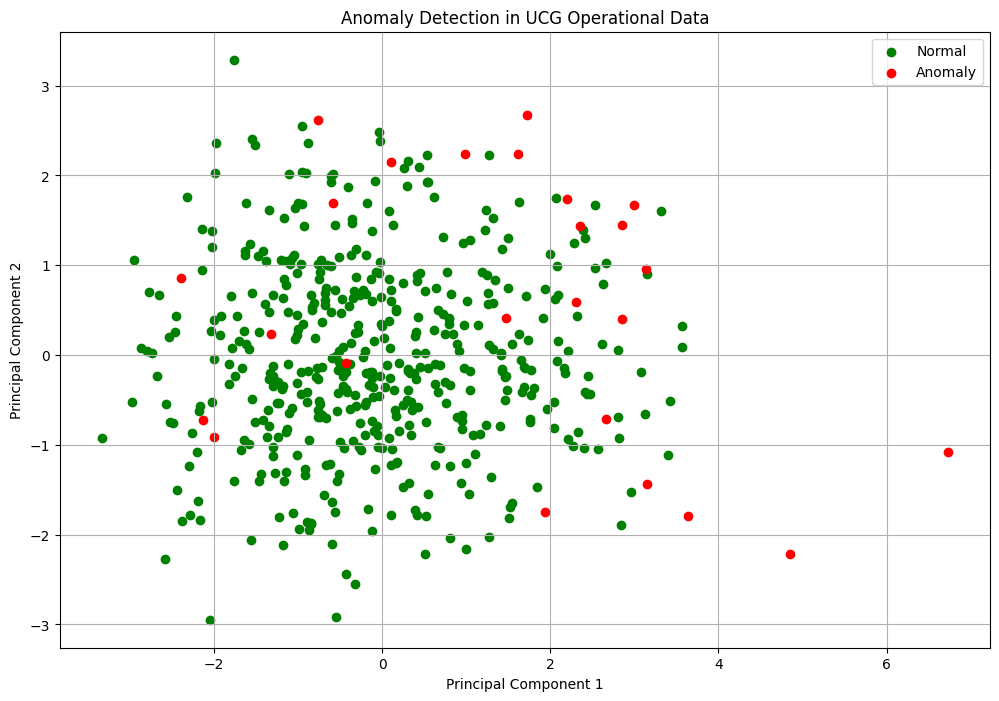


Top 10 Anomalies:
     Fixed carbon  Volatile matter       Ash  Moisture  Seam thickness  \
199      0.254158         0.291747  0.377743  1.386872              10   
20       0.466468         0.201402  0.289933  4.040110              10   
105      0.380067         0.417220  0.126826  1.499369               9   
262      0.083382         0.458804  0.291595  1.121541               4   
496      0.262763         0.412405  0.450528  0.861797               9   
209      0.660747         0.406244  0.417972  1.553380               3   
325      0.248362         0.391451  0.029179  2.055267               9   
177      0.465482         0.409641  0.225100  4.805120              10   
259      0.410228         0.345620  0.229543  4.279284               3   
348      0.288709         0.264188  0.092699  3.399186               3   

     Seam depth  Operating pressure  Permeability  Calorific value       CGR  \
199   65.732357         8829.808246      0.009895      5815.753672  3.944302   
20   1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the data
data = pd.read_excel('UCG Data.xlsx')

# Display basic info
print("Data shape:", data.shape)
print("\nFirst 5 rows:")
print(data.head())

# Select relevant features - all numerical columns
features = data.columns.tolist()

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[features])

# Apply PCA for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Train Isolation Forest model
model = IsolationForest(n_estimators=100,
                        contamination=0.05,  # expected proportion of anomalies
                        random_state=42)
model.fit(scaled_data)

# Predict anomalies
anomaly_scores = model.decision_function(scaled_data)
data['anomaly_score'] = anomaly_scores
data['anomaly'] = model.predict(scaled_data)

# Visualize results
plt.figure(figsize=(12, 8))

# Plot normal points
normal = data[data['anomaly'] == 1]
plt.scatter(principal_components[data['anomaly'] == 1, 0],
            principal_components[data['anomaly'] == 1, 1],
            c='green', label='Normal')

# Plot anomalies
anomalies = data[data['anomaly'] == -1]
plt.scatter(principal_components[data['anomaly'] == -1, 0],
            principal_components[data['anomaly'] == -1, 1],
            c='red', label='Anomaly')

plt.title('Anomaly Detection in UCG Operational Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

# Display top anomalies
print("\nTop 10 Anomalies:")
print(anomalies.sort_values('anomaly_score').head(10)[features + ['anomaly_score']])

The Isolation Forest algorithm identified approximately 5% of the data points
as anomalies (based on the contamination parameter).

The anomalies appear to be cases where multiple parameters show extreme values simultaneously, which could indicate:

1. Abnormal pressure conditions

2. Unexpected permeability changes

3. Irregular calorific values

4. Extreme seam thickness or depth measurements
